# 练习任务1: 替换不同的backbone进行消融实验

In [1]:
import pandas as pd
import numpy as np
import os
import time
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Concatenate, Conv2D, MaxPooling2D, UpSampling2D, Dropout,BatchNormalization,DepthwiseConv2D,add, Activation,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler,CSVLogger
from tensorflow.keras.layers import Lambda
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import backend as K
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score, roc_curve, auc
import h5py
import gdal
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import cv2
from PIL import Image

## patches producing

In [2]:
def regular_crop(imagearray, crop_sz,step=256):
    data_all = []
    for i in np.arange(1):
        data = []
        x=0
#         src_img_row,src_img_col=(imagearray.size)[0:2]
        row_num = ((imagearray.shape)[0] - step) // step  ###最多能裁剪几行 几列
        col_num=((imagearray.shape)[1] - step) // step
    #print(row_num,col_num)
        x_start=0
        y_start=0
        for h in range(row_num):
            for w in range(col_num):
                crop_img = imagearray[crop_sz*h+y_start:crop_sz*(h+1)+y_start, crop_sz*w+x_start:crop_sz*(w+1)+x_start,:]               
#                 crop_img= imagearray.crop((step * h, step * w,step * h + crop_sz,step * w + crop_sz))
                data.append(crop_img)
                x=x+1
                # if x % 10 ==0:
                    # print("processing....patch:"+str(i)+"...No.:"+str(x))
                    
        data=np.array(data)
        # print("processing....patch:"+str(i)+"..Total.No.:"+str(data.shape))
        if i == 0:
            data_all = data
        else:
            data_all=np.concatenate((data_all, data), axis = 0)
    return data_all
def label_hot(label,n_label=1):
    listlabel=[]
    for i in label:
        mask=i.flatten()
        mask=to_categorical(mask, num_classes=n_label)
        listlabel.append(mask)
    msk=np.asarray(listlabel,dtype='uint16')
    msk=msk.reshape((label.shape[0],label.shape[1],label.shape[2],n_label))
#     print(msk.shape)
    return msk
 
def changelabel(arr,a):
    arr=np.array(arr)
    new=arr*0
    new[np.where(arr==a)]=1
    return new
def get_normalized_patches(data,value,n_label=1):
    img = data[:,:,:,0:3]/value
    msk = data[:,:,:,-1]
    # msk = changelabel(msk,4)
    msk = label_hot(msk,n_label)
    # msk = np.expand_dims(msk,axis=3)
    return img,msk
def post_normalize_image(img,value):
    return img/value
def patches_generator(allimage,crop_sz):
    allarray=[]
    for index, value in enumerate(allimage):
        # print(value.shape)
        singlearr=regular_crop(value,crop_sz)
    # allarray.append(array)
        if index == 0:
            allarray = singlearr
            # print(allarray.shape,singlearr.shape)
        else:
            allarray=np.concatenate((allarray, singlearr), axis = 0)
            # print(allarray.shape)
    print(allarray.shape)
    return(allarray)
def plot_func(data,label,key):
    fig=plt.figure(figsize=(25,5))
    for i in range(16):
        plt.subplot(2,8,i+1)
        plt.imshow(Image.fromarray(np.uint8((data[i,:,:,:3])*255)))
    plt.show()
    fig=plt.figure(figsize=(25,5))
    for i in range(16):
        plt.subplot(2,8,i+1)
        plt.imshow((label[i,:,:,key]),cmap="gray")
    plt.show()
def val_plot_func(data,label,pred,key):
    fig=plt.figure(figsize=(25,5))
    for i in range(16):
        plt.subplot(2,8,i+1)
        plt.imshow(Image.fromarray(np.uint8((data[i,:,:,:3])*255)))
    plt.show()
    fig=plt.figure(figsize=(25,5))
    for i in range(16):
        plt.subplot(2,8,i+1)
        plt.imshow((label[i,:,:,key]),cmap="gray")
    plt.show()
    fig=plt.figure(figsize=(25,5))
    for i in range(16):
        plt.subplot(2,8,i+1)
        plt.imshow((pred[i,:,:,key]),cmap="gray")
    plt.show()

In [3]:
class1_hdf5_path ='.\data\kaggle_rgb_4b_6c.hdf5'
fd = h5py.File(class1_hdf5_path)
fd.keys()
data=fd['data']
label=fd['label']
label=changelabel(label,4)
# fd.close
print(data.shape,label.shape)
n_label=2

(15, 3840, 3840, 3) (15, 3840, 3840, 1)


In [4]:
allimage=np.concatenate((data,label),axis=3)
# print(allimage.shape)
allpatches=patches_generator(allimage[:-1],256)
images,labels=get_normalized_patches(allpatches,10000.0,n_label)
print(images.shape,labels.shape)
testimage=allimage[-1,:,:,:-1]
testlabel=allimage[-1,:,:,-1]
print(testimage.shape,testlabel.shape)

(2744, 256, 256, 4)
(2744, 256, 256, 3) (2744, 256, 256, 2)
(3840, 3840, 3) (3840, 3840)


(2195, 256, 256, 3) (549, 256, 256, 3) (2195, 256, 256, 2) (549, 256, 256, 2)


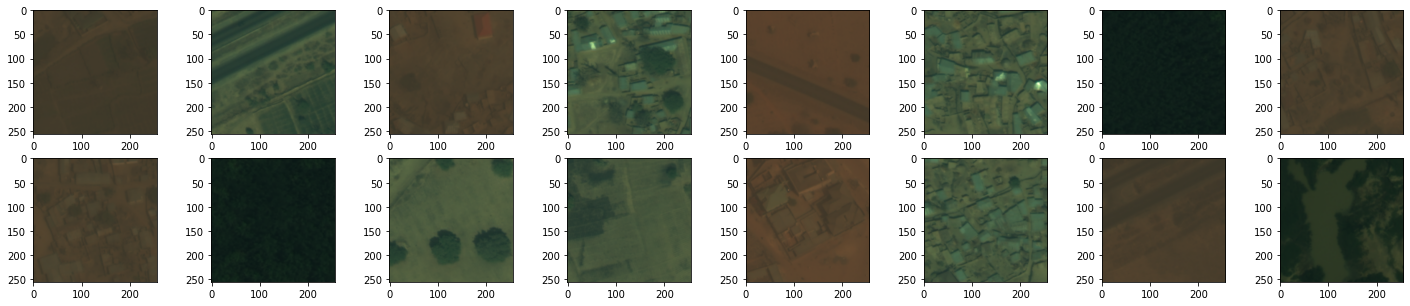

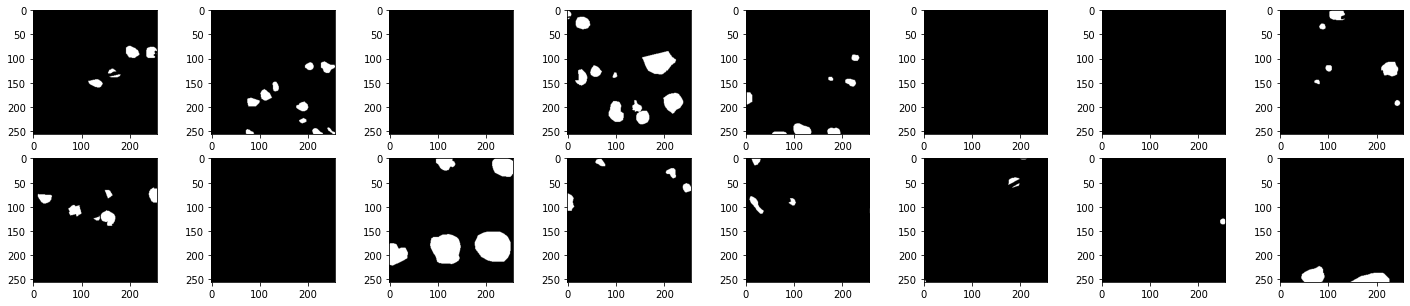

In [ ]:
xtrain,xtest,ytrain,ytest=train_test_split(images,labels,test_size=0.2,random_state=42)
print(xtrain.shape,xtest.shape,ytrain.shape,ytest.shape)
plot_func(xtrain,ytrain,1)

## # Model Training

* 构建ResNet50 backbone DeepLabV3+

In [ ]:
class all_model(object):
    def __init__(self,loss,loss_weights,optimizer,metrics,input_height,input_width,nclass,nchannel):
        self.LOSS = loss
        self.OPTIMIZER = optimizer
        self.METRICS = metrics
        self.input_height = input_height
        self.input_width=input_width
        self.nClasses=nclass
        self.nchannel=nchannel
        self.model = None
        self.img_input=Input(shape=(self.input_height, self.input_width, self.nchannel))
        self.loss_weights=loss_weights
    
       ## RESNET50_head    
    def identity_block(self,input_tensor, kernel_size, filters, stage, block,dilation_rate=1):

        filters1, filters2, filters3 = filters

        conv_name_base = 'res' + str(stage) + block + '_branch'
        bn_name_base = 'bn' + str(stage) + block + '_branch'

        x = Conv2D(filters1, (1, 1), name=conv_name_base + '2a')(input_tensor)
        x = BatchNormalization(name=bn_name_base + '2a')(x)
        x = Activation('relu')(x)

        x = Conv2D(filters2, kernel_size,padding='same', dilation_rate=dilation_rate,name=conv_name_base + '2b')(x)
        x = BatchNormalization( name=bn_name_base + '2b')(x)
        x = Activation('relu')(x)

        x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
        x = BatchNormalization(name=bn_name_base + '2c')(x)

        x = add([x, input_tensor])
        x = Activation('relu')(x)
        return x

    def conv_block(self,input_tensor, kernel_size, filters, stage, block,strides=(2, 2),dilation_rate=1):
        filters1, filters2, filters3 = filters

        conv_name_base = 'res' + str(stage) + block + '_branch'
        bn_name_base = 'bn' + str(stage) + block + '_branch'

        x = Conv2D(filters1, (1, 1), strides=strides,name=conv_name_base + '2a')(input_tensor)
        x = BatchNormalization(name=bn_name_base + '2a')(x)
        x = Activation('relu')(x)

        x = Conv2D(filters2, kernel_size,padding='same',dilation_rate=dilation_rate, name=conv_name_base + '2b')(x)
        x = BatchNormalization(name=bn_name_base + '2b')(x)
        x = Activation('relu')(x)

        x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
        x = BatchNormalization(name=bn_name_base + '2c')(x)

        shortcut = Conv2D(filters3, (1, 1), strides=strides, name=conv_name_base + '1')(input_tensor)
        shortcut = BatchNormalization(name=bn_name_base + '1')(shortcut)

        x = add([x, shortcut])
        x = Activation('relu')(x)
        return x

    def RESNET50_head(self):
        input_shape=self.img_input
        x = Conv2D(64, (3,3), strides=(2, 2), name='conv1',padding='same')(input_shape)
        f1 = x # 128

        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling2D((3, 3),strides=(2, 2),padding='same')(x)

        x = self.conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
        x = self.identity_block(x, 3, [64, 64, 256], stage=2, block='b')
        x = self.identity_block(x, 3, [64, 64, 256], stage=2, block='c')
        f2 = x # 128

        x = self.conv_block(x, 3, [128, 128, 512], stage=3, block='a')
        x = self.identity_block(x, 3, [128, 128, 512], stage=3, block='b')
        x = self.identity_block(x, 3, [128, 128, 512], stage=3, block='c')
        x = self.identity_block(x, 3, [128, 128, 512], stage=3, block='d')
        f3 = x # 64

        x = self.conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
        x = self.identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
        x = self.identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
        x = self.identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
        x = self.identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
        x = self.identity_block(x, 3, [256, 256, 1024], stage=4, block='f')
        f4 = x # 32

        x = self.conv_block(x, 3, [512, 512, 2048], stage=5, block='a',strides=(1, 1))
        x = self.identity_block(x, 3, [512, 512, 2048], stage=5, block='b',dilation_rate=2)
        x = self.identity_block(x, 3, [512, 512, 2048], stage=5, block='c',dilation_rate=2)
        f5 = x # 32
        return input_shape,[f1, f2, f3, f4, f5] 
    

    ## DEEPLAB V3 PLUS

    def interpolation(self,x, shape):
        h_to, w_to = shape
        # Bilinear Interpolation (Default method of this tf function is method=ResizeMethod.BILINEAR)
        resized = tf.image.resize(x, [h_to, w_to])
        return resized
        
    def SepConv_BN(self,x, filters, prefix, stride=1, kernel_size=3, rate=1, epsilon=1e-5):

        x = DepthwiseConv2D((kernel_size, kernel_size), strides=(stride, stride), dilation_rate=(rate, rate),padding='same', use_bias=False, name=prefix + '_depthwise')(x)
        x = BatchNormalization(name=prefix + '_depthwise_BN', epsilon=epsilon)(x)
        x = Activation('relu')(x)
        x = Conv2D(filters, (1, 1), padding='same',use_bias=False, name=prefix + '_pointwise')(x)
        x = BatchNormalization(name=prefix + '_pointwise_BN', epsilon=epsilon)(x)
        x = Activation('relu')(x)

        return x
    def DEEPLABV3plus(self):
        inputs=self.img_input
        XCEPTION_input2, levels = self.RESNET50_head()
        [f1, f2, f3, f4, f5] = levels
        print(K.int_shape(f1),K.int_shape(f2),K.int_shape(f3),K.int_shape(f4),K.int_shape(f5))
        #F3 32,F4=F5=16
        b4 = GlobalAveragePooling2D()(f5)

        # from (b_size, channels)->(b_size, 1, 1, channels)
        b4 = Lambda(lambda x: K.expand_dims(x, 1))(b4)
        b4 = Lambda(lambda x: K.expand_dims(x, 1))(b4)
        b4 = Conv2D(256, (1, 1), padding='same',use_bias=False, name='image_pooling')(b4)
        b4 = BatchNormalization(name='image_pooling_BN', epsilon=1e-5)(b4)
        b4 = Activation('relu')(b4)
        # upsample. have to use compat because of the option align_corners
        size_before = K.int_shape(f5)
        b4 = Lambda(self.interpolation, arguments={'shape': (size_before[1], size_before[2])})(b4)
#         print(K.int_shape(b4))

    # simple 1x1
        b0 = Conv2D(256, (1, 1), padding='same', use_bias=False, name='aspp0')(f5)
        b0 = BatchNormalization(name='aspp0_BN', epsilon=1e-5)(b0)
        b0 = Activation('relu', name='aspp0_activation')(b0)    
        # Dilated conv block
        atrous_rates = (6, 12, 18)

        # rate = 6 (12)
        b1 = self.SepConv_BN(f5, 256, 'aspp1',rate=atrous_rates[0])
        # rate = 12 (24)
        b2 = self.SepConv_BN(f5, 256, 'aspp2',rate=atrous_rates[1])
        # rate = 18 (36)
        b3 = self.SepConv_BN(f5, 256, 'aspp3',rate=atrous_rates[2])

        # concatenate ASPP branches & project
        x = Concatenate()([b4, b0, b1, b2, b3])
        x = Conv2D(256, (1, 1), padding='same',use_bias=False, name='concat_projection')(x)
        x = BatchNormalization(name='concat_projection_BN')(x)
        x = Activation('relu')(x)
        x = Dropout(0.1)(x)
        # X=16
        # DeepLab v.3+ decoder
#         size_before2 = tf.keras.backend.int_shape(f4)
#         x = Lambda(self.interpolation, arguments={'shape': (size_before2[1], size_before2[2])})(x)
        x = UpSampling2D(size=(4,4), data_format='channels_last', interpolation='bilinear', name='4x_Upsampling1')(x)

        dec_skip1 = Conv2D(48, (1, 1), padding='same',use_bias=False, name='feature_projection0')(f2)
        dec_skip1 = BatchNormalization(name='feature_projection0_BN', epsilon=1e-5)(dec_skip1)
        dec_skip1 = Activation(tf.nn.relu)(dec_skip1)
        x = Concatenate()([x, dec_skip1])
        # X=64
        x = self.SepConv_BN(x, 256, 'decoder_conv0')
        x = self.SepConv_BN(x, 256, 'decoder_conv1')      
        x = UpSampling2D(size=(4,4), data_format='channels_last', interpolation='bilinear', name='4x_Upsampling2')(x)
        # X=256
#         x = Conv2D(classes, (1, 1), padding='same', name=last_layer_name)(x)
#         size_before3 = tf.keras.backend.int_shape(inputs)
#         x = Lambda(self.interpolation, arguments={'shape': (size_before3[1], size_before3[2])})(x)

        outputs=Conv2D(filters=self.nClasses,kernel_size=1,strides=1,padding="same",name="final_outputs")(x)
        outputs = Activation(activation='softmax')(outputs)

        self.deeplabv3model=Model(inputs=inputs,outputs=outputs)
        self.deeplabv3model.compile(optimizer=self.OPTIMIZER, loss=self.LOSS, metrics=self.METRICS)
        return self.deeplabv3model

In [ ]:
loss='categorical_crossentropy'#'binary_crossentropy'
optimizer=Adam()#Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)#Adam()#SGD(),Adamax(),Adadelta()R
loss_weights=''
metrics=['accuracy']
input_height=256
input_width=256
batch_size=15
epoch=20
nclass=n_label
nchannel=xtrain.shape[-1]
num_train=xtrain.shape[0]
num_val=xtest.shape[0]
ATM=all_model(loss,loss_weights,optimizer,metrics,input_height,input_width,nclass,nchannel)
nickname='DEEPLABV3plus'

In [ ]:
model=ATM.DEEPLABV3plus()#FCN8,UNET_VGG,UNET_MINI,SQUEESE_UNET,DEEPLABV3plus
model.summary()

(None, 128, 128, 64) (None, 64, 64, 256) (None, 32, 32, 512) (None, 16, 16, 1024) (None, 16, 16, 2048)
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 1792        input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 128, 128, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_368 (Activation)     (None, 128, 128, 64) 0           batch_normalization_6[0

In [30]:
begin_time = time.time()          
checkpoint_DIR = "./practice1_prediction\\"
if not os.path.exists(checkpoint_DIR):
    os.makedirs(checkpoint_DIR) 
model_checkpoint = ModelCheckpoint(filepath=checkpoint_DIR+nickname+"-{epoch:02d}e-val_loss{val_loss:2f}.hdf5",monitor="val_loss",save_best_only=True,mode='auto')
# histories=LossHistory()
csvlogger =CSVLogger(filename=checkpoint_DIR+nickname+'-'+str(epoch)+'-log.csv', separator=',', append=False)
# result=model.fit(xtrain, ytrain, batch_size=batch_size, epochs=epoch, verbose=1, shuffle=True,validation_data=(xtest, ytest),callbacks=[model_checkpoint,CSVLogger])
result=model.fit(xtrain, ytrain, batch_size=batch_size, epochs=epoch, verbose=1, shuffle=True,validation_data=(xtest, ytest),callbacks=[model_checkpoint,csvlogger])
end_time = time.time()
print('time lapsing {0} s \n'.format(end_time - begin_time))

Epoch 1/20
147/147 [==============================] - 680s 4s/step - loss: 0.1994 - accuracy: 0.9280 - val_loss: 0.2894 - val_accuracy: 0.9224


C:\Users\agrs\.conda\envs\keras\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
147/147 [==============================] - 39s 264ms/step - loss: 0.1653 - accuracy: 0.9368 - val_loss: 0.3838 - val_accuracy: 0.9224
Epoch 3/20
147/147 [==============================] - 39s 263ms/step - loss: 0.1572 - accuracy: 0.9388 - val_loss: 0.3954 - val_accuracy: 0.9224
Epoch 4/20
147/147 [==============================] - 38s 258ms/step - loss: 0.1505 - accuracy: 0.9415 - val_loss: 0.3029 - val_accuracy: 0.9239
Epoch 5/20
147/147 [==============================] - 37s 253ms/step - loss: 0.1502 - accuracy: 0.9411 - val_loss: 0.1492 - val_accuracy: 0.9367
Epoch 6/20
147/147 [==============================] - 37s 253ms/step - loss: 0.1415 - accuracy: 0.9442 - val_loss: 0.2121 - val_accuracy: 0.9340
Epoch 7/20
147/147 [==============================] - 37s 255ms/step - loss: 0.1361 - accuracy: 0.9460 - val_loss: 0.1911 - val_accuracy: 0.9341
Epoch 8/20
147/147 [==============================] - 37s 255ms/step - loss: 0.1336 - accuracy: 0.9472 - val_loss: 0.3260 - val_ac

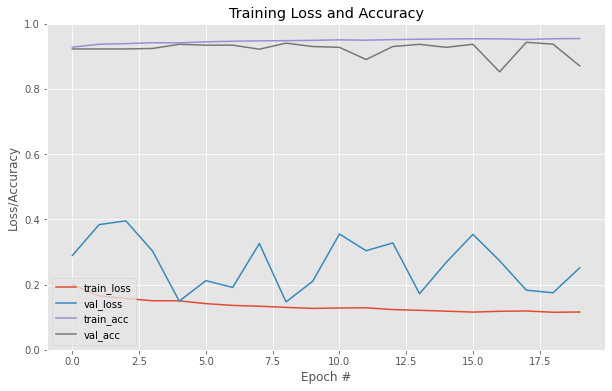

In [35]:
def plot_fig(H,outdir):
    N=len(result.history['loss'])
    plt.style.use("ggplot")
    plt.figure(figsize=(10,6))
    plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
    plt.ylim(0,1)

    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.savefig(outdir)
plot_fig(result,nickname+"_Loss_Acc_epoch.png")

In [36]:
i=0
pred=model.predict(xtest[:200],batch_size=20)

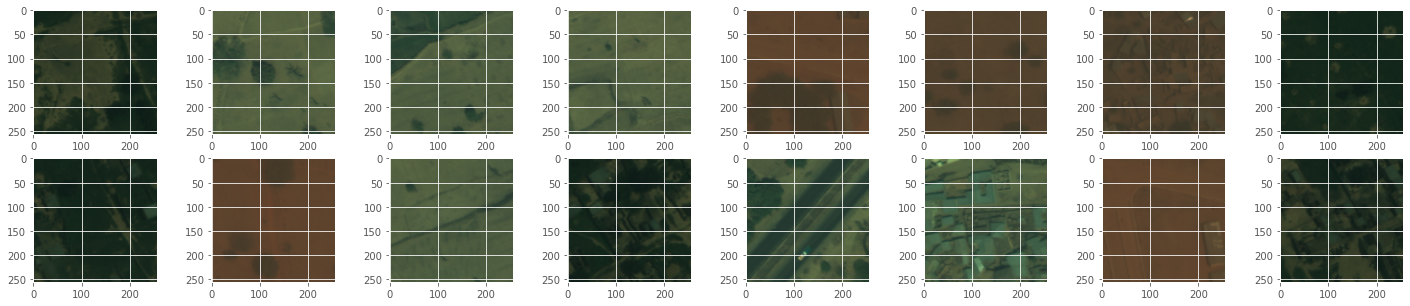

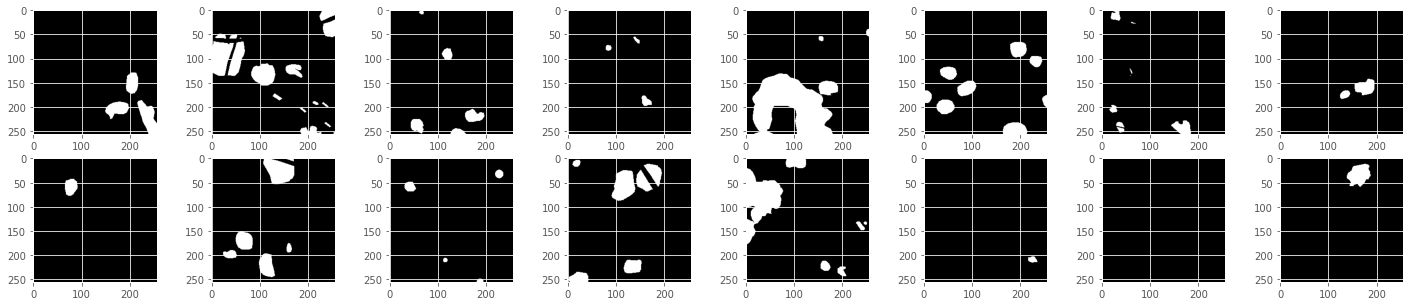

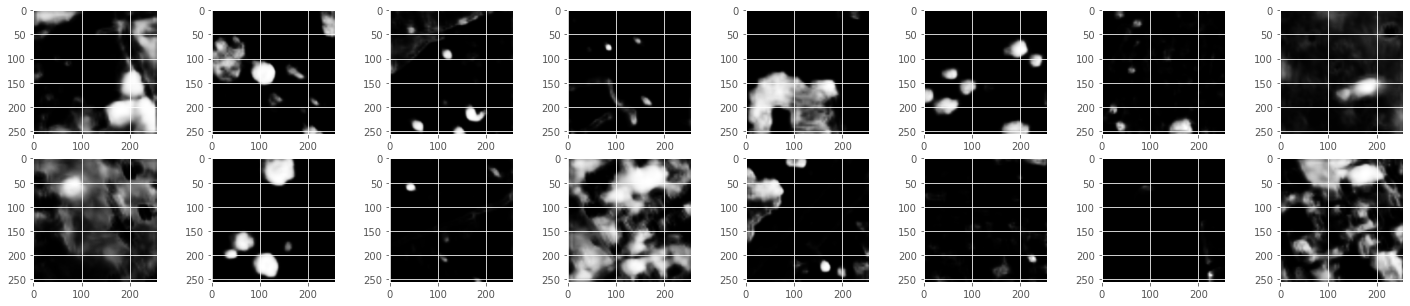

In [37]:
val_plot_func(xtest[i:i+20],ytest[i:i+20],pred[i:i+20],1)
i+=20

## Prediction

In [39]:
def predict(image,ProductDir,shotname,threshold,n_label,is_score=1):
    #print("[INFO] loading network...")
    stride=128   #128
    image_size=256
    h,w,c = image.shape
    padding_h = (h//stride + 1) * stride
    padding_w = (w//stride + 1) * stride
    padding_img = np.zeros((padding_h,padding_w,c),dtype=np.float32)
    padding_img[0:h, 0:w, :] = image[:, :, :]
    padding_img = padding_img.astype("float")
    # padding_img = img_to_array(padding_img)
    # 	print ('src:',padding_img.shape)
    mask_whole = np.zeros((padding_h,padding_w,n_label),dtype=np.float32)
    print('all images='+str((padding_h//stride)*(padding_w//stride)))
    for i in range(padding_h//stride):
        if i % 10 ==0 :
            print('processing.....' +str(i)+'    of   '+str(padding_h//stride))
        for j in range(padding_w//stride):
            crop = padding_img[i*stride:i*stride+image_size,j*stride:j*stride+image_size,:]
            #         print(crop.shape)
            ch,cw,c = crop.shape
            if ch != image_size or cw != image_size:
            #             print ('invalid size!')
                continue
            crop = np.expand_dims(crop, axis=0)
            pred = model.predict(crop,verbose=0)
#             print(pred.shape)
            #pred=np.argmax(pred, axis=-1)
            #print (np.unique(pred))
            pred = pred.reshape((image_size,image_size,n_label)).astype(np.float32)
#             print(pred.shape)
            #print 'pred:',pred.shape
            mask_whole[i*stride:i*stride+image_size,j*stride:j*stride+image_size,:] = pred[:,:,:]
            #mask_whole[i * stride:i * stride + image_size , j * stride:j * stride + image_size,:] = pred[:,:,:]

    img_final = mask_whole[0:h, 0:w,:]
#    print(np.mean(img_final))
    imgarr=np.zeros((h,w),dtype=np.uint8)

#    if is_score==1:
#        for k in range(n_label):
#            im=np.array((img_final[:,:,i]*256),dtype=np.uint8)
#            imwrite((ProductDir+shotname+'_score'+str(k)+'.png'),im)
#            imgarr[img_final[:,:,i]>threshold]=1
#            imgarr[img_final[:,:,i]<=threshold]=0
#            im=np.array(imgarr*255,dtype=np.uint8)   
#            cv2.imwrite((ProductDir+shotname+'_pred'+str(k)+'.png'),im)

    #img_final[img_final>=1]=1
    pred=np.argmax(img_final, axis=-1)
    cv2.imwrite((ProductDir+shotname+'_prdlabels.png'),pred*255)
    #print (np.unique(img_final))
    return pred,img_final

def out_report(gt_arr,label_arr,out_csv):
    # gt_arr=Load_image_by_Gdal(gt)
    gt_reshape=gt_arr.reshape((gt_arr.shape[0]*gt_arr.shape[1],1))
    label_reshape=label_arr.reshape((label_arr.shape[0]*label_arr.shape[1],1))
    acc=classification_report(gt_reshape,label_reshape,output_dict=True)
    df=pd.DataFrame(acc).transpose()
    df.to_csv(out_csv,index=True)   

## Evaluation

In [40]:
PREDICTION_DIR = "./prediction\\"+nickname+'\\'
if not os.path.exists(PREDICTION_DIR):
    os.makedirs(PREDICTION_DIR)
msk_result,mask_arr=predict(testimage/10000.0,PREDICTION_DIR,nickname,0.5,n_label)
out_report(testlabel,msk_result,PREDICTION_DIR+'matrics.csv')

all images=961
processing.....0    of   31
processing.....10    of   31
processing.....20    of   31
processing.....30    of   31


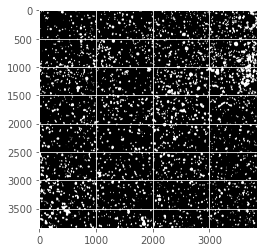

In [41]:
plt.imshow(testlabel,cmap='gray')

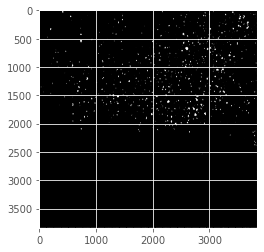

In [42]:
plt.imshow(msk_result,cmap='gray')